In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pylab as pl
import numpy as np
import matplotlib.colors as mc
import matplotlib as mpl
from matplotlib import rc
from matplotlib import cm
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes


from numpy import pi, sqrt, cos, sin, arctan2, linspace, log, exp, sinh, arcsinh
import astropy.io.fits as pyfits 
from scipy.spatial.distance import cdist
from coords import *

import scipy.integrate as integrate
from scipy import special
import warnings
warnings.filterwarnings('ignore')


#rc('text', usetex=True)

In [3]:
data = np.loadtxt('Star-Map_-10.5_wCC-ISAAC_J2000_comp.dat')


# Star Counts

In [4]:

l_data  = data[:,0]
b_data  = data[:,1] 
lstar   = data[:,2]  
bstar   = data[:,3] 
N       = data[:,4] 
N_error = data[:,5] 
RA      = data[:,6] 
DE      = data[:,7]

Nl, Nb = 421, 181

l       = l_data.reshape(Nl,Nb)
b       = b_data.reshape(Nl,Nb)
lstar   = lstar.reshape(Nl,Nb)
bstar   = bstar.reshape(Nl,Nb)
N       = N.reshape(Nl,Nb)
N_error = N_error.reshape(Nl,Nb)
RA      = RA.reshape(Nl,Nb)
DE      = DE.reshape(Nl,Nb)

# Stellar Densities

In [5]:
## Galactic bulge model from Gallego-Cano 2020
# using fixed input params from Launhardt+2002 
# some stuff based on Dwek+1995
## Converted to stellar density 
# Launhardt et al. 2002 Bar density


def Calc_L02_Bar_rho(s,l,b):
    l = np.deg2rad(l+0.056)
    b = np.deg2rad(b+0.046)
    D = 8.2
    x = -s * cos(b) * cos(l)
    z = -D + (s * cos(b) * cos(l))
    y = s * sin(b) 

    rho0  = 0.8
    N0    = 9.90 #stars arcmin-2
    ax    = 1.1 #kpc
    ay    = 0.36 #kpc
    az    = 0.22 #kpc
    Cperp = 1.6
    Cpar  = 3.2
    Rperp = ((np.abs(x)/ax)**Cperp + (np.abs(y)/ay)**Cperp)**(1.0/Cperp)
    Rs    = (Rperp**Cpar + (np.abs(z)/az)**Cpar)**(1.0/Cpar)
    rho   = exp(-Rs) ## volume emissivity
    
    return rho
    



## NSD model from Gallego-Cano 2020, eq. 3
## Converted to stellar density 
def NSD_GC20(l,b):
    l = np.deg2rad(l+0.056)
    b = np.deg2rad(b+0.046)
    x,y,z,vx,vy,vz = lbr2xyz(l,b,8.2,0,0,0) # X points to GC, y and z are the projected plane
    
    x = y * 1e3 # pc
    y = z * 1e3 # pc

    R_e   = 116.2 # ± 0.6 [pc] #Effective radius
    I_e   = 19.84 # ± 0.16 stars arcmin−2 #Stellar number density at R_e 
    n     = 0.872#0.782 # ± 0.008
    q     = 0.338 # ± 0.002 #ratio between minor and major axis
    b_n   = 1.9992*n - 0.32 #function of the Sérsic index n
    p     = np.sqrt((x)**2 + ((y)/q)**2)
    
    f     = ((p/R_e)**(1./n) ) -1

    return  I_e * np.exp(-b_n*f) 
    



In [6]:
N_GB.max()

NameError: name 'N_GB' is not defined

In [7]:
################################################
# Loop through the shape of the star count image 
# calculate densities for the Galactic Bulge and 
# NSD, then add them together
################################################

N_GB = np.zeros(shape=np.shape(N))
N_NSD = np.zeros(shape=np.shape(N))

for i in range(Nl):
    for j in range(Nb):
        I = integrate.quad(Calc_L02_Bar_rho, 0, np.inf, args=(l[i][j],b[i][j]))
        N0 = 9.90 #stars arcmin-2
        star_rho = 2*N0*I[0] ## convert to brightness, and then multiply by a stellar density factor (See Gallego-Cano 2020 eq. 2)

        N_GB[i][j] = star_rho
        
        nsd = NSD_GC20(l[i][j],b[i][j])
        N_NSD[i][j] = nsd
        
NN = N_NSD + N_GB

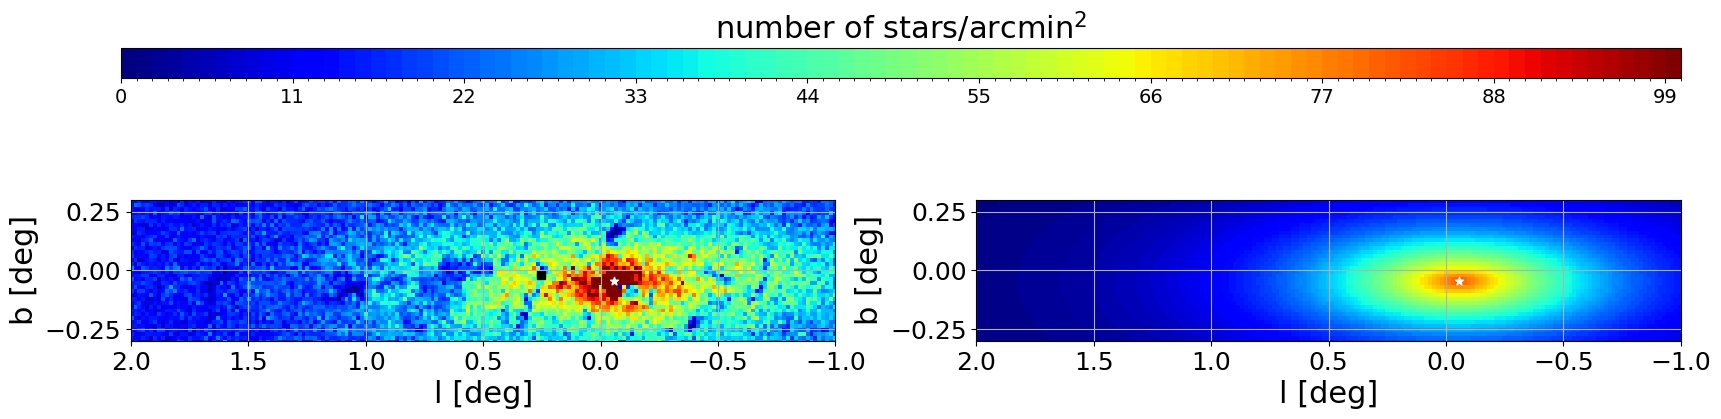

In [8]:
# plot number of stars in each bin
fig, ax = pl.subplots(nrows=1, ncols=2, figsize=(20, 5))

levels  = np.linspace(0,100,101)
norm    = mc.BoundaryNorm(levels, 256)
cmap    = 'jet'
extent  = [l.max(),l.min(),b.max(),b.min()]
xlim = [2,-1]
ylim = [-0.3,0.3]

IM0 = ax[0].imshow(N.T,norm=norm,cmap=cmap,origin='lower',extent=extent)
ax[0].set_xlabel('l [deg]',fontsize=22)
ax[0].set_ylabel('b [deg]',fontsize=22)
ax[0].set_aspect('equal')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].grid()
ax[0].tick_params(labelsize=18) 
ax[0].scatter(-0.056, -0.046, marker = "*", s=35, color='white')
ax[0].scatter(0.255, -0.02, marker = "s", s=35, color='k')



#plot the density profile
IM1 = ax[1].imshow(NN.T,norm=norm,cmap=cmap,origin='lower',extent=extent)
ax[1].set_xlabel('l [deg]',fontsize=22)
ax[1].set_ylabel('b [deg]',fontsize=22)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].grid()
ax[1].tick_params(labelsize=18) 
ax[1].scatter(-0.056, -0.046, marker = "*", s=35, color='white')

cax = fig.add_axes([0.12, .88, 0.78, 0.06])
cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    spacing='proportional',
    orientation='horizontal',
    location='bottom'

)
cb.ax.tick_params(labelsize=14)  # set your label size here



cb.ax.set_title(r'number of stars/arcmin$^{2}$',fontsize=22)

pl.savefig('GC2020_counts_density_comparison.pdf', bbox_inches='tight')



In [151]:
N_NSD.max(), N_GB.max()

(80.11552190041239, 0.03191563379730969)

In [209]:
CENTLPIX, CENTBPIX

(209, 91)

In [232]:
l[209][0], l[CENTLPIX][0]

(-0.0476667, -0.0643333)

In [233]:
###SAVE THE PLOTS AS FITS###
#model_peak_ind = np.where(NN == NN.max())
#CRPIX1, CRPIX2 = model_peak_ind[0][0], model_peak_ind[1][0] 
bb = np.flip(b)
CDELT1 = l[::,0][0] - l[::,0][1] 
CDELT2 = b[0][0] - b[0][1]

CENTLVAL = l[(l>=-0.057) & (l<-0.04) & (bb>=-0.047) & (bb<-0.03)][0]
CENTBVAL = bb[(l>=-0.057) & (l<-0.04) & (bb>=-0.047) & (bb<-0.03)][0]
CENTLPIX = np.where(l==CENTL)[0][0] + 1 # 0th index in wcs is counted as pixel #1
CENTBPIX = np.where(bb==CENTB)[1][0] + 1 # 0th index in wcs is counted as pixel #1



########################
### NISHIYAMA COUNTS ###
########################

nishiyama_data = np.flip(N.T,0)
hdu_nishiyama = pyfits.PrimaryHDU(data=nishiyama_data)
counts_header = hdu_nishiyama.header
counts_header.set('ctype1',"GLON-TAN")
counts_header.set('crval1', CENTLVAL)
counts_header.set('cdelt1', -CDELT1 )
counts_header.set('crpix1', CENTLPIX)
counts_header.set('cunit1',"deg" )

counts_header.set('ctype2',"GLAT-TAN")
counts_header.set('crval2',  CENTBVAL)
counts_header.set('cdelt2', CDELT2)
counts_header.set('crpix2', CENTBPIX)
counts_header.set('cunit2', "deg")

pyfits.writeto('./FITS/nishiyama_counts.fits', nishiyama_data, counts_header, overwrite=True)



####################
### MODEL COUNTS ###
####################

model_data = np.flip(NN.T,0)
hdu_model = pyfits.PrimaryHDU(data=model_data)
model_header = hdu_model.header
model_header.set('ctype1',"GLON-TAN")
model_header.set('crval1', CENTLVAL)
model_header.set('cdelt1', -CDELT1 )
model_header.set('crpix1', CENTLPIX)
model_header.set('cunit1',"deg" )

model_header.set('ctype2',"GLAT-TAN")
model_header.set('crval2',  CENTBVAL)
model_header.set('cdelt2', CDELT2)
model_header.set('crpix2', CENTBPIX)
model_header.set('cunit2', "deg")

pyfits.writeto('./FITS/model_counts.fits', model_data, model_header, overwrite=True)





In [199]:
CENTBPIX, CENTLPIX

(89, 209)